## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import re

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
len(nltk_data)

3914

In [4]:
nltk_data[:3]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

In [5]:
# Split into test and train sets 95:5
random.seed(1234)
train_set, test_set = train_test_split(nltk_data, test_size=0.05, random_state=1234)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

3718
196
[[('This', 'DET'), ('year', 'NOUN'), (',', '.'), ('the', 'DET'), ('average', 'NOUN'), ('of', 'ADP'), ('daily', 'ADJ'), ('contracts', 'NOUN'), ('traded', 'VERB'), ('*', 'X'), ('totaled', 'VERB'), ('9,118', 'NUM'), (',', '.'), ('up', 'ADP'), ('from', 'ADP'), ('4,645', 'NUM'), ('a', 'DET'), ('year', 'NOUN'), ('earlier', 'ADJ'), ('and', 'CONJ'), ('from', 'ADP'), ('917', 'NUM'), ('in', 'ADP'), ('1984', 'NUM'), ('.', '.')], [('First', 'NOUN'), ('of', 'ADP'), ('America', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-1', 'X'), ('now', 'ADV'), ('has', 'VERB'), ('45', 'NUM'), ('banks', 'NOUN'), ('and', 'CONJ'), ('$', '.'), ('12.5', 'NUM'), ('billion', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('assets', 'NOUN'), (',', '.'), ('announced', 'VERB'), ('an', 'DET'), ('agreement', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('acquire', 'VERB'), ('the', 'DET'), ('Peoria', 'NOUN'), (',', '.'), ('Ill.', 'NOUN'), (',', '.'), ('bank', 'NOUN'), ('holding', 'VERB'), ('company', 'NOUN'), ('in', 'ADP'), ('January',

In [6]:
print(test_set[:40])

[[('Ruth', 'NOUN'), ('K.', 'NOUN'), ('Nelson', 'NOUN'), ('Cullowhee', 'NOUN'), (',', '.'), ('N.C', 'NOUN'), ('.', '.')], [('Among', 'ADP'), ('other', 'ADJ'), ('Connecticut', 'NOUN'), ('banks', 'NOUN'), ('whose', 'PRON'), ('shares', 'NOUN'), ('*T*-121', 'X'), ('trade', 'VERB'), ('in', 'ADP'), ('the', 'DET'), ('OTC', 'NOUN'), ('market', 'NOUN'), (',', '.'), ('Society', 'NOUN'), ('for', 'ADP'), ('Savings', 'NOUN'), ('Bancorp', 'NOUN'), (',', '.'), ('based', 'VERB'), ('*', 'X'), ('in', 'ADP'), ('Hartford', 'NOUN'), (',', '.'), ('saw', 'VERB'), ('its', 'PRON'), ('stock', 'NOUN'), ('rise', 'VERB'), ('1', 'NUM'), ('3\\/4', 'NUM'), ('to', 'PRT'), ('18', 'NUM'), ('1\\/4', 'NUM'), ('.', '.')], [('Card', 'NOUN'), ('holders', 'NOUN'), ('who', 'PRON'), ('*T*-59', 'X'), ('receive', 'VERB'), ('the', 'DET'), ('letter', 'NOUN'), ('also', 'ADV'), ('are', 'VERB'), ('eligible', 'ADJ'), ('for', 'ADP'), ('a', 'DET'), ('sweepstakes', 'NOUN'), ('with', 'ADP'), ('Buick', 'NOUN'), ('cars', 'NOUN'), ('or', 'CONJ

In [7]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95799

In [8]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['This',
 'year',
 ',',
 'the',
 'average',
 'of',
 'daily',
 'contracts',
 'traded',
 '*']

In [9]:
# vocabulary
V = set(tokens)
print(len(V))

12073


In [10]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [11]:
T = sorted(T, reverse=True)
print(T)

['X', 'VERB', 'PRT', 'PRON', 'NUM', 'NOUN', 'DET', 'CONJ', 'ADV', 'ADP', 'ADJ', '.']


In [12]:
# Let's see the list of foreign words (tagged with 'X')
print(set([pair for pair in train_tagged_words if pair[1] == 'X']))

{('*T*-171', 'X'), ('*-123', 'X'), ('*-74', 'X'), ('*-132', 'X'), ('&', 'X'), ('*-8', 'X'), ('*T*-166', 'X'), ('*-93', 'X'), ('*T*-138', 'X'), ('*-79', 'X'), ('*T*-125', 'X'), ('*T*-124', 'X'), ('*-144', 'X'), ('*-125', 'X'), ('*T*-34', 'X'), ('*-24', 'X'), ('*-130', 'X'), ('*T*-81', 'X'), ('*-67', 'X'), ('*-25', 'X'), ('*T*-241', 'X'), ('*-59', 'X'), ('*-127', 'X'), ('*T*-141', 'X'), ('*T*-242', 'X'), ('*-114', 'X'), ('*-119', 'X'), ('*-75', 'X'), ('*T*-227', 'X'), ('*-96', 'X'), ('*T*-240', 'X'), ('*-49', 'X'), ('*T*-208', 'X'), ('*T*-259', 'X'), ('*T*-155', 'X'), ('*T*-143', 'X'), ('*T*-49', 'X'), ('*T*-205', 'X'), ('*T*-127', 'X'), ('*T*-16', 'X'), ('*-20', 'X'), ('*T*-67', 'X'), ('*T*-53', 'X'), ('*-101', 'X'), ('*T*-5', 'X'), ('*T*-48', 'X'), ('*-131', 'X'), ('*T*-99', 'X'), ('*T*-17', 'X'), ('*T*-158', 'X'), ('*-28', 'X'), ('*T*-102', 'X'), ('*-81', 'X'), ('*T*-43', 'X'), ('*T*-201', 'X'), ('*-31', 'X'), ('*-164', 'X'), ('*T*-1', 'X'), ('*T*-157', 'X'), ('*-44', 'X'), ('*T*-204'

### Emission Probabilities

In [13]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [14]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [15]:
print(word_given_tag('branch', 'NOUN'))

(6, 27471)


In [16]:
print(word_given_tag('speak', 'NOUN'))

(0, 27471)


### Transition Probabilities

In [17]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [18]:
# examples
print(t2_given_t1(t2='PRON', t1='ADJ'))
print(t2_given_t1('NOUN', 'ADJ'))
print(t2_given_t1(',', 'NOUN'))

(4, 6063)
(4235, 6063)
(0, 27471)


In [19]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)):
        t2_g_t1 = t2_given_t1(t2, t1)
        tags_matrix[i, j] = t2_g_t1[0]/t2_g_t1[1]

In [20]:
tags_matrix

array([[7.48417750e-02, 2.04113930e-01, 1.84651896e-01, 5.63291125e-02,
        2.68987333e-03, 6.21835440e-02, 5.41139245e-02, 1.07594933e-02,
        2.61075944e-02, 1.44936711e-01, 1.64556969e-02, 1.62816450e-01],
       [2.17815652e-01, 1.67622000e-01, 3.12161110e-02, 3.53214554e-02,
        2.26955842e-02, 1.10844307e-01, 1.33617356e-01, 5.57707204e-03,
        8.35011601e-02, 9.14020166e-02, 6.52207583e-02, 3.51665393e-02],
       [1.40065150e-02, 4.02931601e-01, 1.95439742e-03, 1.79153103e-02,
        5.66775240e-02, 2.47882739e-01, 9.96742696e-02, 2.28013028e-03,
        9.77198686e-03, 2.11726390e-02, 8.40390846e-02, 4.16938104e-02],
       [9.39289778e-02, 4.87972498e-01, 1.18365791e-02, 7.63650239e-03,
        7.25467736e-03, 2.07331046e-01, 9.16380342e-03, 4.58190171e-03,
        3.28369625e-02, 2.32913326e-02, 7.36922473e-02, 4.04734649e-02],
       [2.10463732e-01, 1.81331746e-02, 2.70511303e-02, 1.48632575e-03,
        1.84898928e-01, 3.54637325e-01, 2.97265151e-03, 1.33

In [21]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [22]:
tags_df

,X,VERB,PRT,PRON,NUM,NOUN,DET,CONJ,ADV,ADP,ADJ,.
X,0.074842,0.204114,0.184652,0.056329,0.002690,0.062184,0.054114,0.010759,0.026108,0.144937,0.016456,0.162816
VERB,0.217816,0.167622,0.031216,0.035321,0.022696,0.110844,0.133617,0.005577,0.083501,0.091402,0.065221,0.035167
PRT,0.014007,0.402932,0.001954,0.017915,0.056678,0.247883,0.099674,0.002280,0.009772,0.021173,0.084039,0.041694
PRON,0.093929,0.487972,0.011837,0.007637,0.007255,0.207331,0.009164,0.004582,0.032837,0.023291,0.073692,0.040473
NUM,0.210464,0.018133,0.027051,0.001486,0.184899,0.354637,0.002973,0.013377,0.002973,0.035672,0.032402,0.115933
NOUN,0.029231,0.146336,0.043974,0.004769,0.009537,0.264898,0.013250,0.042263,0.017182,0.177023,0.012231,0.239307
DET,0.046197,0.039545,0.000242,0.003749,0.022373,0.638650,0.005442,0.000484,0.012698,0.009191,0.203652,0.017777
CONJ,0.008862,0.158582,0.005131,0.057369,0.041511,0.348881,0.118470,0.000466,0.055970,0.052705,0.118937,0.033116
ADV,0.023263,0.344364,0.014744,0.015400,0.031455,0.031127,0.068480,0.006881,0.081258,0.118611,0.129751,0.134666
ADP,0.035048,0.008522,0.001491,0.070203,0.062001,0.322893,0.322893,0.000959,0.013849,0.016512,0.105785,0.039842


In [23]:
tags_df.loc['.', :]

X       0.027314
VERB    0.088769
PRT     0.002336
PRON    0.065768
NUM     0.080593
NOUN    0.223091
DET     0.173226
CONJ    0.057772
ADV     0.051932
ADP     0.090386
ADJ     0.044654
.       0.094070
Name: ., dtype: float32

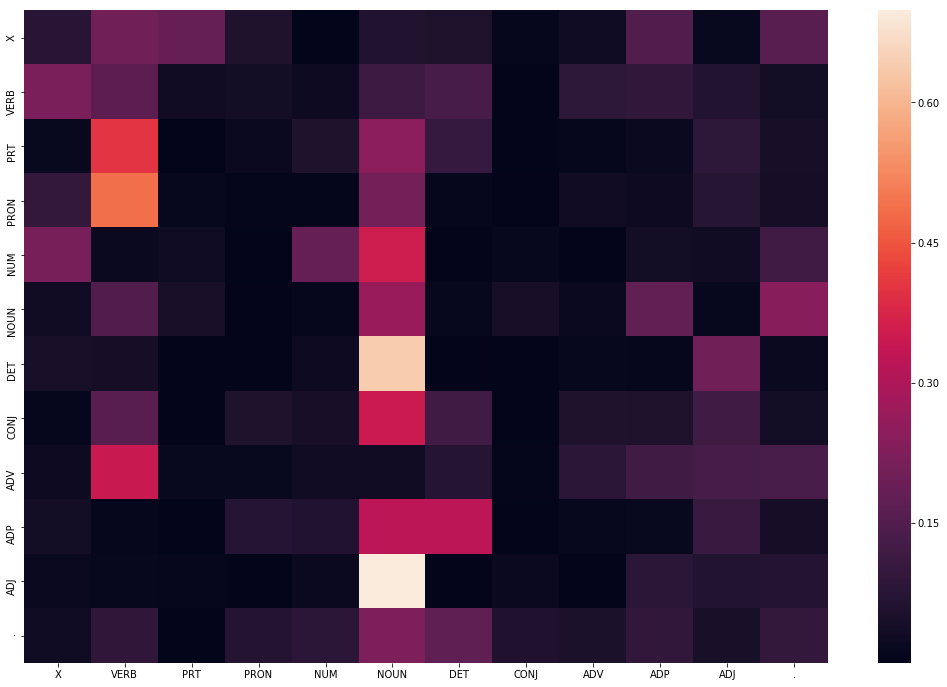

In [24]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

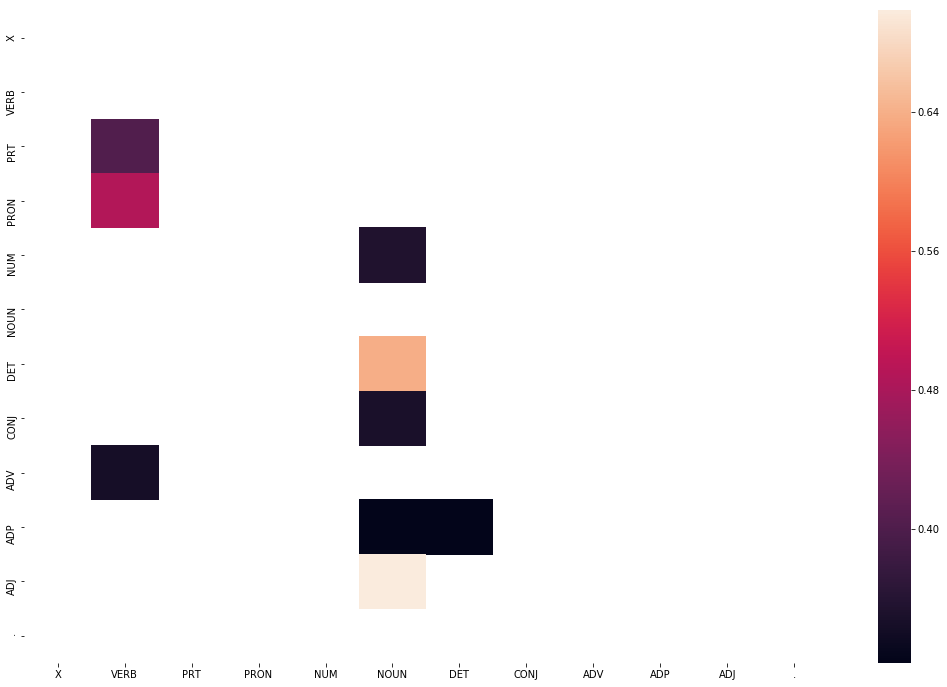

In [25]:
# frequent tags
# filter the df to get P(t2, t1) > 0.3
tags_frequent = tags_df[tags_df>0.3]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### Build the vanilla Viterbi based POS tagger

In [26]:
len(train_tagged_words)

95799

In [27]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    T = sorted(T, reverse=True)
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            word_g_tag = word_given_tag(words[key], tag)
            emission_p = word_g_tag[0]/word_g_tag[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [28]:
# list of tagged words
test_run_base = [tup for sent in test_set for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_set for tup in sent]

In [29]:
len(test_run_base)

4877

In [30]:
len(test_tagged_words)

4877

In [31]:
# tagging the test sentences
start = time.time()
tagged_seq_vanilla_viterbi = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [32]:
print("Time taken in seconds: ", difference)
print("Tagged by Viterbi")
print(tagged_seq_vanilla_viterbi)
print("Original tags")
print(test_run_base)

Time taken in seconds:  340.00916481018066
Tagged by Viterbi
[('Ruth', 'X'), ('K.', 'NOUN'), ('Nelson', 'NOUN'), ('Cullowhee', 'X'), (',', '.'), ('N.C', 'NOUN'), ('.', '.'), ('Among', 'ADP'), ('other', 'ADJ'), ('Connecticut', 'NOUN'), ('banks', 'NOUN'), ('whose', 'PRON'), ('shares', 'NOUN'), ('*T*-121', 'X'), ('trade', 'VERB'), ('in', 'ADP'), ('the', 'DET'), ('OTC', 'NOUN'), ('market', 'NOUN'), (',', '.'), ('Society', 'NOUN'), ('for', 'ADP'), ('Savings', 'NOUN'), ('Bancorp', 'NOUN'), (',', '.'), ('based', 'VERB'), ('*', 'X'), ('in', 'ADP'), ('Hartford', 'NOUN'), (',', '.'), ('saw', 'VERB'), ('its', 'PRON'), ('stock', 'NOUN'), ('rise', 'VERB'), ('1', 'NUM'), ('3\\/4', 'NUM'), ('to', 'PRT'), ('18', 'NUM'), ('1\\/4', 'NUM'), ('.', '.'), ('Card', 'X'), ('holders', 'NOUN'), ('who', 'PRON'), ('*T*-59', 'X'), ('receive', 'VERB'), ('the', 'DET'), ('letter', 'NOUN'), ('also', 'ADV'), ('are', 'VERB'), ('eligible', 'ADJ'), ('for', 'ADP'), ('a', 'DET'), ('sweepstakes', 'X'), ('with', 'ADP'), ('Bui

### It can be seen that words that are unseen in the training set is tagged with a default tag that appears in the tag list

### Solve the problem of unknown words

In [33]:
# specify patterns for tagging {'NUM', 'PRT', 'PRON', 'ADJ', 'VERB', 'CONJ', 'ADP', 'NOUN', 'DET', 'X', 'ADV', '.'}
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense
    (r'.*es$', 'VERB'),               # 3rd singular present
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers    
    (r'.*ful$', 'ADJ'),               # adjectives 
    (r'.*ious$', 'ADJ'),               # adjectives
    (r'.*ble$', 'ADJ'),               # adjectives
    (r'.*ic$', 'ADJ'),               # adjectives
    (r'.*ive$', 'ADJ'),               # adjectives
    (r'.*ic$', 'ADJ'),               # adjectives
    (r'.*est$', 'ADJ'),               # adjectives
    (r'.*ly$', 'ADV'),               # adjectives
    (r'.*ness$', 'NOUN'),               # noun
    (r'^\*', 'X'),
    (r'.*', 'NOUN'),                    # nouns (default)
]

In [34]:
regex_tagger = nltk.RegexpTagger(patterns)
unigram_tagger = nltk.UnigramTagger(train_set, backoff=regex_tagger)
bigram_tagger = nltk.BigramTagger(train_set, backoff=unigram_tagger)

### Let's modify the viterbi algorithm so that the unknown (unseen) words are tagged based on the regex rule based tagger instead of assigning the default tag

In [35]:
# Modified Viterbi Heuristic
def First_Modified_Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    T = sorted(T, reverse=True)
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            word_g_tag = word_given_tag(words[key], tag)
            emission_p = word_g_tag[0]/word_g_tag[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        final_state = ''
        if pmax == 0.0:
            bigram_tag = bigram_tagger.tag(nltk.word_tokenize(words[key]))
            final_state = bigram_tag[0][1]
        else:
            # getting state for which probability is maximum
            final_state = T[p.index(pmax)]
        state.append(final_state)
    return list(zip(words, state))

In [36]:
# tagging the test sentences
start = time.time()
tagged_seq_first_modified_viterbi = First_Modified_Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [37]:
print("Time taken in seconds: ", difference)
print("Tagged by Viterbi")
print(tagged_seq_first_modified_viterbi)
print("Original tags")
print(test_run_base)

Time taken in seconds:  340.291734457016
Tagged by Viterbi
[('Ruth', 'NOUN'), ('K.', 'NOUN'), ('Nelson', 'NOUN'), ('Cullowhee', 'NOUN'), (',', '.'), ('N.C', 'NOUN'), ('.', '.'), ('Among', 'ADP'), ('other', 'ADJ'), ('Connecticut', 'NOUN'), ('banks', 'NOUN'), ('whose', 'PRON'), ('shares', 'NOUN'), ('*T*-121', 'X'), ('trade', 'VERB'), ('in', 'ADP'), ('the', 'DET'), ('OTC', 'NOUN'), ('market', 'NOUN'), (',', '.'), ('Society', 'NOUN'), ('for', 'ADP'), ('Savings', 'NOUN'), ('Bancorp', 'NOUN'), (',', '.'), ('based', 'VERB'), ('*', 'X'), ('in', 'ADP'), ('Hartford', 'NOUN'), (',', '.'), ('saw', 'VERB'), ('its', 'PRON'), ('stock', 'NOUN'), ('rise', 'VERB'), ('1', 'NUM'), ('3\\/4', 'NUM'), ('to', 'PRT'), ('18', 'NUM'), ('1\\/4', 'NUM'), ('.', '.'), ('Card', 'NOUN'), ('holders', 'NOUN'), ('who', 'PRON'), ('*T*-59', 'X'), ('receive', 'VERB'), ('the', 'DET'), ('letter', 'NOUN'), ('also', 'ADV'), ('are', 'VERB'), ('eligible', 'ADJ'), ('for', 'ADP'), ('a', 'DET'), ('sweepstakes', 'VERB'), ('with', 'AD

### Let's modify the vanila Viterbi with another technique to assign the tag based on the highest transition probability on encountering an unknown word without multiplying it by emission probability (which is 0 for unknown words)

In [38]:
# Modified Viterbi Heuristic
def Second_Modified_Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    T = sorted(T, reverse=True)
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        state_probabilities = [] 
        transition_probabilities = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]              
            else:
                transition_p = tags_df.loc[state[-1], tag]                  
                
            # compute emission and state probabilities
            word_g_tag = word_given_tag(words[key], tag)
            emission_p = word_g_tag[0]/word_g_tag[1]
            state_probability = emission_p * transition_p
            transition_probabilities.append(transition_p)
            state_probabilities.append(state_probability)
            
        pmax = max(state_probabilities)
        if pmax == 0.0:
            # we are dealing with a new word which was not in the dictionary. 
            # If the word starts with '*' for example '*T*-223' we will tag it as 'X' as an unknown word. 
            if re.search("^\*.*", words[key]):
                state_max = 'X'
            # For all the other words, let's assign the tag based on the highest transition probability
            else:
                pmax = max(transition_probabilities)
                state_max =  T[transition_probabilities.index(pmax)]
        else:
            # getting state for which probability is maximum
            state_max = T[state_probabilities.index(pmax)] 
            
        state.append(state_max)
    return list(zip(words, state))

In [39]:
# tagging the test sentences
start = time.time()
tagged_seq_second_modified_viterbi = Second_Modified_Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [40]:
print("Time taken in seconds: ", difference)
print("Tagged by Viterbi")
print(tagged_seq_second_modified_viterbi)
print("Original tags")
print(test_run_base)

Time taken in seconds:  339.5654754638672
Tagged by Viterbi
[('Ruth', 'NOUN'), ('K.', 'NOUN'), ('Nelson', 'NOUN'), ('Cullowhee', 'NOUN'), (',', '.'), ('N.C', 'NOUN'), ('.', '.'), ('Among', 'ADP'), ('other', 'ADJ'), ('Connecticut', 'NOUN'), ('banks', 'NOUN'), ('whose', 'PRON'), ('shares', 'NOUN'), ('*T*-121', 'X'), ('trade', 'VERB'), ('in', 'ADP'), ('the', 'DET'), ('OTC', 'NOUN'), ('market', 'NOUN'), (',', '.'), ('Society', 'NOUN'), ('for', 'ADP'), ('Savings', 'NOUN'), ('Bancorp', 'NOUN'), (',', '.'), ('based', 'VERB'), ('*', 'X'), ('in', 'ADP'), ('Hartford', 'NOUN'), (',', '.'), ('saw', 'VERB'), ('its', 'PRON'), ('stock', 'NOUN'), ('rise', 'VERB'), ('1', 'NUM'), ('3\\/4', 'NUM'), ('to', 'PRT'), ('18', 'NUM'), ('1\\/4', 'NUM'), ('.', '.'), ('Card', 'NOUN'), ('holders', 'NOUN'), ('who', 'PRON'), ('*T*-59', 'X'), ('receive', 'VERB'), ('the', 'DET'), ('letter', 'NOUN'), ('also', 'ADV'), ('are', 'VERB'), ('eligible', 'ADJ'), ('for', 'ADP'), ('a', 'DET'), ('sweepstakes', 'NOUN'), ('with', 'A

#### Evaluating tagging accuracy

In [41]:
# accuracy of vanilla Viterbi
check = [i for i, j in zip(tagged_seq_vanilla_viterbi, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq_vanilla_viterbi)
accuracy

0.910600779167521

In [42]:
incorrect_tags_vanilla_viterbi = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_vanilla_viterbi, test_run_base)) if j[0]!=j[1]]
incorrect_tags_vanilla_viterbi

[[('.', '.'), (('Ruth', 'X'), ('Ruth', 'NOUN'))],
 [('Nelson', 'NOUN'), (('Cullowhee', 'X'), ('Cullowhee', 'NOUN'))],
 [('.', '.'), (('Card', 'X'), ('Card', 'NOUN'))],
 [('a', 'DET'), (('sweepstakes', 'X'), ('sweepstakes', 'NOUN'))],
 [('Maxwell', 'NOUN'), (('R.D.', 'X'), ('R.D.', 'NOUN'))],
 [('R.D.', 'NOUN'), (('Vos', 'X'), ('Vos', 'NOUN'))],
 [(',', '.'), (('N.Y', 'X'), ('N.Y', 'NOUN'))],
 [('The', 'DET'), (('Perch', 'X'), ('Perch', 'NOUN'))],
 [('and', 'CONJ'), (('Dolphin', 'X'), ('Dolphin', 'NOUN'))],
 [('producing', 'VERB'), (('early', 'ADV'), ('early', 'ADJ'))],
 [('the', 'DET'), (('Seahorse', 'X'), ('Seahorse', 'NOUN'))],
 [('and', 'CONJ'), (('Tarwhine', 'X'), ('Tarwhine', 'NOUN'))],
 [('be', 'VERB'), (('refunded', 'X'), ('refunded', 'VERB'))],
 [('newly', 'ADV'), (('fattened', 'X'), ('fattened', 'VERB'))],
 [('a', 'DET'), (('disembodied', 'X'), ('disembodied', 'ADJ'))],
 [('disembodied', 'ADJ'), (('male', 'ADJ'), ('male', 'NOUN'))],
 [('.', '.'), (('Otherwise', 'X'), ('Otherwi

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [43]:
# accuracy of Viterbi combined with Rules based tagging 
check = [i for i, j in zip(tagged_seq_first_modified_viterbi, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq_first_modified_viterbi)
accuracy

0.955915521837195

## The accuracy with the first modification has increased from `~91%` to `~96%`

In [44]:
incorrect_tagged_cases_fir_mod_viterbi = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_first_modified_viterbi, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases_fir_mod_viterbi

[[('a', 'DET'), (('sweepstakes', 'VERB'), ('sweepstakes', 'NOUN'))],
 [('producing', 'VERB'), (('early', 'ADV'), ('early', 'ADJ'))],
 [('a', 'DET'), (('disembodied', 'VERB'), ('disembodied', 'ADJ'))],
 [('disembodied', 'ADJ'), (('male', 'ADJ'), ('male', 'NOUN'))],
 [('.', '.'), (('Otherwise', 'NOUN'), ('Otherwise', 'ADV'))],
 [('the', 'DET'), (('300-day', 'NOUN'), ('300-day', 'ADJ'))],
 [('oldest', 'ADJ'), (('bell-ringing', 'VERB'), ('bell-ringing', 'ADJ'))],
 [('remains', 'VERB'), (('male-only', 'ADV'), ('male-only', 'ADJ'))],
 [('fact', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('*T*-230', 'X'), (("'s", 'PRT'), ("'s", 'VERB'))],
 [('particularly', 'ADV'), (('galling', 'VERB'), ('galling', 'ADJ'))],
 [('the', 'DET'), (('sole', 'NOUN'), ('sole', 'ADJ'))],
 [("'s", 'PRT'), (('short-lived', 'VERB'), ('short-lived', 'ADJ'))],
 [('funds', 'NOUN'), (('mirrors', 'NOUN'), ('mirrors', 'VERB'))],
 [('the', 'DET'), (('1920s', 'NUM'), ('1920s', 'NOUN'))],
 [(',', '.'), (('as', 'ADP'), ('as'

In [45]:
# accuracy of Viterbi modified to use the tag with highest transition probability for unknown words
check = [i for i, j in zip(tagged_seq_second_modified_viterbi, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq_second_modified_viterbi)
accuracy

0.9413573918392454

## The accuracy with the second modification has increased from `~91%` to `~94%`

In [46]:
incorrect_tagged_cases_sec_mod_viterbi = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_second_modified_viterbi, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases_sec_mod_viterbi

[[('producing', 'VERB'), (('early', 'ADV'), ('early', 'ADJ'))],
 [('be', 'VERB'), (('refunded', 'X'), ('refunded', 'VERB'))],
 [('a', 'DET'), (('disembodied', 'NOUN'), ('disembodied', 'ADJ'))],
 [('.', '.'), (('Otherwise', 'NOUN'), ('Otherwise', 'ADV'))],
 [('the', 'DET'), (('300-day', 'NOUN'), ('300-day', 'ADJ'))],
 [('oldest', 'ADJ'), (('bell-ringing', 'NOUN'), ('bell-ringing', 'ADJ'))],
 [('in', 'ADP'), (('1637', 'NOUN'), ('1637', 'NUM'))],
 [('remains', 'VERB'), (('male-only', 'X'), ('male-only', 'ADJ'))],
 [('fact', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('*T*-230', 'X'), (("'s", 'PRT'), ("'s", 'VERB'))],
 [('particularly', 'ADV'), (('galling', 'VERB'), ('galling', 'ADJ'))],
 [('the', 'DET'), (('sole', 'NOUN'), ('sole', 'ADJ'))],
 [("'s", 'PRT'), (('Cathedral', 'VERB'), ('Cathedral', 'NOUN'))],
 [("'s", 'PRT'), (('short-lived', 'VERB'), ('short-lived', 'ADJ'))],
 [('Communists', 'NOUN'), (('seized', 'NOUN'), ('seized', 'VERB'))],
 [('in', 'ADP'), (('1917', 'NOUN'), ('1917

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

### Let us run the vanilla viterbi algorithm on the test words from the assigment.

In [47]:
f = open("Test_sentences.txt", "r")
te = f.read()

test_words_assignment = []
test_words_assignment = nltk.word_tokenize(te)
test_words_assignment[:10]

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google',
 '.']

In [48]:
# tagging the test sentences
start = time.time()
tagged_seq_assignment_vanilla_viterbi = Viterbi(test_words_assignment)
end = time.time()
difference = end-start

In [49]:
print("Time taken in seconds: ", difference)
print("Tagged by Viterbi")
print(tagged_seq_assignment_vanilla_viterbi)

Time taken in seconds:  12.937574863433838
Tagged by Viterbi
[('Android', 'X'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'X'), ('.', '.'), ('stf', 'X'), ('skj', 'X'), ('skudsd', 'X'), ('dslkdsu', 'X'), ('Android', 'X'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'X'), ('worldwide', 'X'), ('on', 'ADP'), ('smartphones', 'X'), ('since', 'ADP'), ('2011', 'X'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'X'), ('.', '.'), ('Google', 'X'), ('and', 'CONJ'), ('Twitter', 'X'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'X'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'X'), ("'s", 'PRT'), ('firehose', 'X'), ('.', '.'), ('Twitter', 'X'), ('is', 'VERB'), ('an', 'DET'), ('online', 'X'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), 

### Let us run the first modified viterbi algorithm (adding the rule based tagger) on the test words from the assigment.

In [50]:
# tagging the test sentences
start = time.time()
tagged_seq_assignment_fir_mod_viterbi = First_Modified_Viterbi(test_words_assignment)
end = time.time()
difference = end-start

In [51]:
print("Time taken in seconds: ", difference)
print("Tagged by Viterbi")
print(tagged_seq_assignment_fir_mod_viterbi)

Time taken in seconds:  13.016779661178589
Tagged by Viterbi
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('stf', 'NOUN'), ('skj', 'NOUN'), ('skudsd', 'NOUN'), ('dslkdsu', 'NOUN'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'

### Words that are incorrectly tagged by vanilla viterbi but correctly tagged by first modified viterbi (adding the rule based tagger)

In [52]:
word_diff_list = []
for fir_mod_tups in tagged_seq_assignment_fir_mod_viterbi:
    for van_tups in tagged_seq_assignment_vanilla_viterbi:
        if fir_mod_tups[0] == van_tups[0] and fir_mod_tups[1] != van_tups[1]:
            tup = (van_tups, fir_mod_tups)
            word_diff_list.append(tup)
            break

In [53]:
word_diff_list

[(('Android', 'X'), ('Android', 'NOUN')),
 (('Google', 'X'), ('Google', 'NOUN')),
 (('stf', 'X'), ('stf', 'NOUN')),
 (('skj', 'X'), ('skj', 'NOUN')),
 (('skudsd', 'X'), ('skudsd', 'NOUN')),
 (('dslkdsu', 'X'), ('dslkdsu', 'NOUN')),
 (('Android', 'X'), ('Android', 'NOUN')),
 (('OS', 'X'), ('OS', 'NOUN')),
 (('worldwide', 'X'), ('worldwide', 'NOUN')),
 (('smartphones', 'X'), ('smartphones', 'VERB')),
 (('2011', 'X'), ('2011', 'NUM')),
 (('2013', 'X'), ('2013', 'NUM')),
 (('Google', 'X'), ('Google', 'NOUN')),
 (('Twitter', 'X'), ('Twitter', 'NOUN')),
 (('2015', 'X'), ('2015', 'NUM')),
 (('Google', 'X'), ('Google', 'NOUN')),
 (('Twitter', 'X'), ('Twitter', 'NOUN')),
 (('firehose', 'X'), ('firehose', 'NOUN')),
 (('Twitter', 'X'), ('Twitter', 'NOUN')),
 (('online', 'X'), ('online', 'NOUN')),
 (('interact', 'X'), ('interact', 'NOUN')),
 (('messages', 'X'), ('messages', 'VERB')),
 (('tweets', 'X'), ('tweets', 'NOUN')),
 (('domineering', 'X'), ('domineering', 'VERB')),
 (('personality', 'X'), (

### It can be seen that words like `Android`, `Google`, `FIFA`, `Cup`, etc are tagged correctly after the modification

### Let us run the second modified viterbi algorithm (tagging with the highest transition probability) on the test words from the assigment.

In [54]:
# tagging the test sentences
start = time.time()
tagged_seq_assignment_sec_mod_viterbi = Second_Modified_Viterbi(test_words_assignment)
end = time.time()
difference = end-start

In [55]:
print("Time taken in seconds: ", difference)
print("Tagged by Viterbi")
print(tagged_seq_assignment_sec_mod_viterbi)

Time taken in seconds:  13.028166770935059
Tagged by Viterbi
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('stf', 'NOUN'), ('skj', 'NOUN'), ('skudsd', 'NOUN'), ('dslkdsu', 'NOUN'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NOUN'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NOUN'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NOUN'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'

### Words that are incorrectly tagged by vanilla viterbi but correctly tagged by second modified viterbi (tagging with the highest transition probability)

In [56]:
word_diff_list = []
for sec_mod_tups in tagged_seq_assignment_sec_mod_viterbi:
    for van_tups in tagged_seq_assignment_vanilla_viterbi:
        if sec_mod_tups[0] == van_tups[0] and sec_mod_tups[1] != van_tups[1]:
            tup = (van_tups, sec_mod_tups)
            word_diff_list.append(tup)
            break

In [57]:
word_diff_list

[(('Android', 'X'), ('Android', 'NOUN')),
 (('Google', 'X'), ('Google', 'NOUN')),
 (('stf', 'X'), ('stf', 'NOUN')),
 (('skj', 'X'), ('skj', 'NOUN')),
 (('skudsd', 'X'), ('skudsd', 'NOUN')),
 (('dslkdsu', 'X'), ('dslkdsu', 'NOUN')),
 (('Android', 'X'), ('Android', 'NOUN')),
 (('OS', 'X'), ('OS', 'NOUN')),
 (('worldwide', 'X'), ('worldwide', 'NOUN')),
 (('smartphones', 'X'), ('smartphones', 'NOUN')),
 (('2011', 'X'), ('2011', 'NOUN')),
 (('2013', 'X'), ('2013', 'NOUN')),
 (('Google', 'X'), ('Google', 'NOUN')),
 (('Twitter', 'X'), ('Twitter', 'NOUN')),
 (('2015', 'X'), ('2015', 'NOUN')),
 (('Twitter', 'X'), ('Twitter', 'VERB')),
 (('firehose', 'X'), ('firehose', 'VERB')),
 (('Twitter', 'X'), ('Twitter', 'NOUN')),
 (('online', 'X'), ('online', 'NOUN')),
 (('interact', 'X'), ('interact', 'NOUN')),
 (('messages', 'X'), ('messages', 'NOUN')),
 (('tweets', 'X'), ('tweets', 'NOUN')),
 (('domineering', 'X'), ('domineering', 'NOUN')),
 (('personality', 'X'), ('personality', 'NOUN')),
 (('2018', '

### It can be seen that words like `Android`, `Tournament`, `FIFA`, `NASA`, etc are tagged correctly after the modification

# Thus the 2 modified viterbi techniques has shown some non trivial improvement in performance